<a href="https://colab.research.google.com/github/farshid101/Thesis-2024/blob/main/TS/google-bert_bert-base-multilingual-cased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Performing checks for the resources available

In [7]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [8]:
!pip install transformers

## Importing necessary packages

In [9]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [10]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading training data

In [12]:
import pandas as pd

# Attempt to read the file with ISO-8859-1 encoding
data = pd.read_csv('/content/filtered.csv')


In [13]:
# Add an ID column starting from 1
data['PID'] = range(1, len(data) + 1)

In [14]:
data.head()

,text,label,PID
0,তোমরা সবাই এই ভাই তাকে একটু কোরোভিডিও গুলো দে...,positive,1
1,🎯 ব্রহ্মপুত্র নদের ওপর নির্মিত ৯.১৫ কিলোমিটারে...,positive,2
2,😊 ধন্যবাদ মাননীয় প্রধানমন্ত্রী শেখ হাসিনা,positive,3
3,2022 এর 25 এ জুন 🥰🥰,neutral,4
4,অনুভূতিটা এত সুন্দর ভাষায় প্রকাশ করতে পারতেছি...,positive,5


In [15]:
import pandas as pd

# Function to rename a single column
def change_column_name(df, old_name, new_name):
    df = df.rename(columns={old_name: new_name})
    return df

# Assuming df is your DataFrame
data = change_column_name(data, old_name="label", new_name="labels")
data = change_column_name(data, old_name="Comments", new_name="text")
data.head() # Display the first few rows of the DataFrame
#text


# Move the ID column to the first position
cols = ['PID'] + [col for col in data.columns if col != 'PID']
data = data[cols]

data.head()

,PID,text,labels
0,1,তোমরা সবাই এই ভাই তাকে একটু কোরোভিডিও গুলো দে...,positive
1,2,🎯 ব্রহ্মপুত্র নদের ওপর নির্মিত ৯.১৫ কিলোমিটারে...,positive
2,3,😊 ধন্যবাদ মাননীয় প্রধানমন্ত্রী শেখ হাসিনা,positive
3,4,2022 এর 25 এ জুন 🥰🥰,neutral
4,5,অনুভূতিটা এত সুন্দর ভাষায় প্রকাশ করতে পারতেছি...,positive


In [16]:


# Keep only the specified three columns
# Replace 'column1', 'column2', 'column3' with your actual column names
data = data[['PID', 'text', 'labels']]

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
print(data.sample(10))


Number of training sentences: 5,724

       PID                                               text    labels
3426  3427                          জনগণ চাচ্ছে আপনি কবরে জান  negative
2846  2847  নেত্রী শেখ হাসিনার সকল মেঘা উদ্যোগোলো এগিয়ে যা...   neutral
5159  5160  অহংকারের ফল এগুলো, সিলেটের জন্য সরকারের চোখ অন...  negative
622    623  যে কথা সুনলাম সব মাল নাকি বিদেশী তার মানে বুজা...   neutral
4818  4819  হে দয়াময় আল্লাহ তায়ালা আপনি আমাদের অতীতের সকল ...  negative
3697  3698                                   আহা সোনা গো আমার   neutral
5620  5621                              ট্রাক চলা বন্ধ করা হক  negative
324    325                             অসাধারণ গান পদ্দা সেতু  positive
2142  2143  এক্সপ্রেস ওয়েটি বরিশাল হয়ে কুয়াকাটা পর্যন্ত হল...  positive
3425  3426                           মানুষ কাঁদে মানুষের জন্য  negative


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# # Read the file with ISO-8859-1 encoding
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nazir Sir/spam - spam.csv', encoding='ISO-8859-1')

# First, split the data into training and temp (test + validation)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Then split temp_data into test and validation sets (50% each of temp_data, so 15% of the total for each)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [18]:
train_df

,PID,text,labels
527,528,প্রদ্মা সেতু বাংলাদেশের সেরা সেতু ❤❤,positive
4885,4886,নিয়ম কানুন মেনে গাড়ি চালাতে হবে।,neutral
2339,2340,আমাদের বাংলাদেশ একসময় পারমাণবিক শক্তি শালী হবে 😊😊,positive
2497,2498,একই জায়গায় করলে নিরাপত্তার জন্য ঝুঁকিপূর্ণ হবে...,negative
1665,1666,", এত বৃষ্টিতে ও কাগজটা ভিজলো না কেমনে? 😮",neutral
...,...,...,...
3772,3773,আবু সাইদ কে যে পুলিশ সবার সামনে গুলি করেছে তাক...,negative
5191,5192,তোগো মত বেজন্মা সাংবাদিক গুলো যে এতদিন অতিরঞ্জ...,positive
5226,5227,পেঁয়াজের এক ট্রাক দুর্ঘটনার কারণেই কি তাহলে প...,negative
5390,5391,এবার ট্রাক চলা বন্ধ,negative


In [19]:
test_df

,PID,text,labels
3887,3888,জয় বাংলা স্লোগান যারা দেয় সব গুলায় চোর বাটপার,negative
4463,4464,পদ্মা সেতুর নির্মাণ প্রকল্পের মতই আপনাদের তথ্য...,positive
4353,4354,সত্যি বলতে শেখ হাসিনা না হলে এই পদ্মা সেতু হত ...,positive
1973,1974,রাস্তা এবং তার চারপাশ সুন্দর করার দায়িত্ব সরকা...,positive
2603,2604,কত টাকা শেখ পরিবারের পকেটে ঢুকেছে তার হিসাব জা...,neutral
...,...,...,...
2715,2716,জাতির আব্বা বলেছিল না? চাটার দল সব খায়। উনার ...,negative
3858,3859,ডঃ মুহাম্মদ ইউনুস স্যার খেলা দেখতে ভালোই লাগছে...,positive
3874,3875,সব কিছুর লাভ দেখলে হয় না। কিছু আছে প্রয়জন-যেমন...,positive
2473,2474,এই।।সমষত।।উন্নয়ন। কথা।।শুনলে <>চোখে।। পানি।।এস...,neutral


In [20]:
val_df

,PID,text,labels
453,454,এই আবালের কথা শুনে কমেন্ট করা আর বিষ খাওয়া একই...,negative
1844,1845,আমাদের দেশের গৌরব ধন্যবাদ আপনাকে প্রধানমন্ত্রী...,positive
2574,2575,এবার বুঝে দেখেন সবাই?কি করেছে লীগ জারজরা,negative
4894,4895,মোটরসাইকেল এক্সিডেন্ট করছে তাই আপনেরা বন্ধ করে...,negative
4368,4369,সকল প্রসংশা মহান আল্লাহ। শেখ হাসিনা কে জানায় হ...,positive
...,...,...,...
4457,4458,“ইন্নাল্লাহা মা’আস সবেরিন”“নিশ্চয় আল্লাহ ধৈর্...,neutral
3768,3769,লাশ দেখে চোখের পানি পরে না...,negative
4126,4127,: এগিয়ে যাও। উন্নত মানের সরকারি দরকার। তাহল...,positive
1765,1766,সমস্যা কি আমরা প্রবাসীরা গান মারিয়ে পাঠামু আরো...,negative


In [21]:
train_df['labels'].value_counts()

,count
labels,
positive,1965
negative,1431
neutral,1183


In [22]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [23]:
train_df['labels'].value_counts()

,count
labels,
2,1965
0,1431
1,1183


### Loading `train_sentences` and `train_labels`

In [24]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [25]:
data.labels.unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [26]:
class_names = [
            'positive', 'neutral', 'negative'
]

## Loading the validation data

In [27]:
val_df['labels'] = le.transform(val_df['labels'])

In [28]:

val_df['labels'].value_counts()

,count
labels,
2,225
0,183
1,165


### Loading `val_sentences` and `val_labels`

In [29]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['labels'].values

In [30]:
val_labels

array([0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       0, 0, 2, 1, 2, 1, 0, 0, 0, 1, 1, 0, 2, 2, 1, 1, 2, 0, 1, 1, 2, 1,
       1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1,
       0, 0, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0,
       1, 1, 2, 2, 0, 1, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0,
       1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 1, 0, 0,
       2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 2, 0, 2, 1, 2, 0, 0, 2, 1, 0, 0, 2,
       0, 0, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1,
       2, 2, 1, 1, 2, 0, 2, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2,
       2, 1, 2, 0, 0, 1, 0, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1,
       0, 1, 2, 0, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 2, 1, 0, 1, 1, 1, 0, 2,
       1, 2, 0, 1, 2, 0, 1, 1, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2,
       2, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 2, 2, 2,
       0, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 2,

## Helper Functions

#### 1) Update Interval Function

In [31]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [32]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [33]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [34]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [35]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [36]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [37]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [38]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [39]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [40]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [41]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [42]:
#model_name = 'sagorsarker/bangla-bert-base'

model_name = 'google-bert/bert-base-multilingual-cased'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading google-bert/bert-base-multilingual-cased tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [43]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

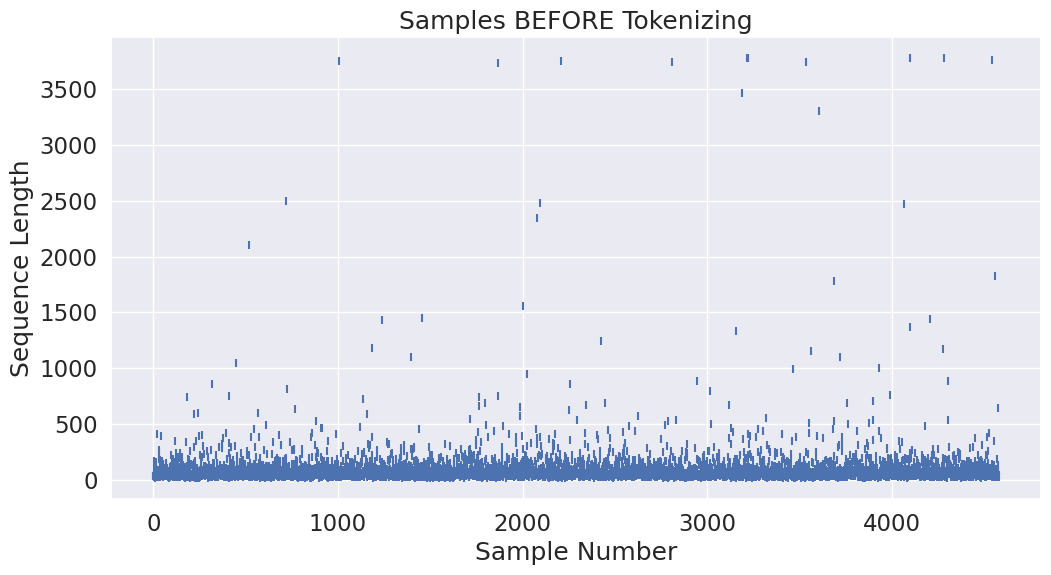

In [44]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [45]:
max_input_length = 300

In [46]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 4,579 training samples...
  Tokenized 0 samples.
  Tokenized 500 samples.
  Tokenized 1,000 samples.
  Tokenized 1,500 samples.
  Tokenized 2,000 samples.
  Tokenized 2,500 samples.
  Tokenized 3,000 samples.
  Tokenized 3,500 samples.
  Tokenized 4,000 samples.
  Tokenized 4,500 samples.
DONE.
     4,579 samples


In [47]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

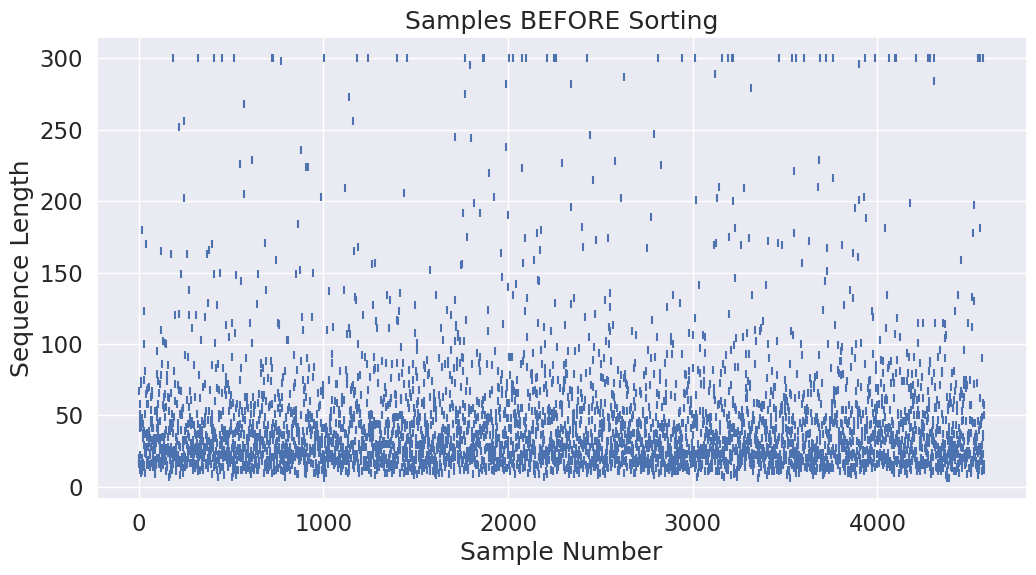

In [48]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [49]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [50]:
train_samples[0:5]

[([101, 100, 100, 27470, 100, 102], 1),
 ([101, 39325, 100024, 76446, 28777, 102], 1),
 ([101, 100024, 34388, 17634, 14704, 102], 1),
 ([101, 97717, 45201, 37855, 53761, 102], 1),
 ([101, 100024, 100, 46085, 100, 102], 2)]

In [51]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 6
Longest sample: 300


In [52]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

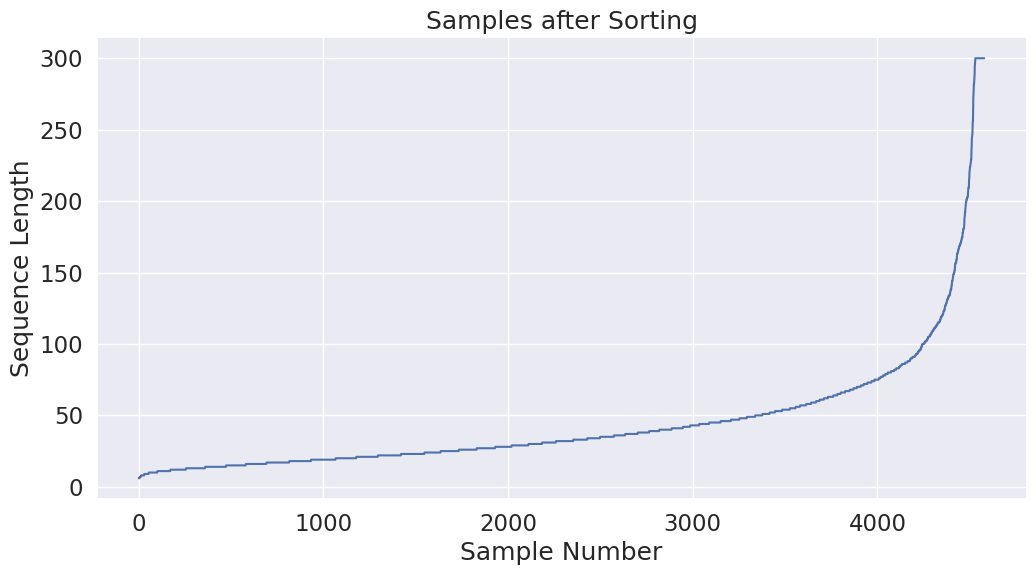

In [53]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [54]:
train_samples[0]

([101, 100, 100, 27470, 100, 102], 1)

In [55]:
batch_size = 16

In [56]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.

  DONE - 287 batches.


In [57]:
print(batch_ordered_sentences[0])

[[101, 71083, 49178, 17511, 11737, 56836, 978, 12079, 22756, 74765, 15691, 971, 40102, 937, 60398, 56251, 93168, 102], [101, 28777, 948, 16166, 14176, 18262, 975, 102433, 11199, 26109, 14998, 117, 82937, 15002, 30023, 948, 12235, 102], [101, 100024, 970, 12235, 944, 11737, 968, 12235, 955, 58354, 43004, 955, 22756, 20725, 12235, 16755, 100, 102], [101, 46438, 958, 12079, 111229, 40102, 13458, 14770, 13104, 15002, 971, 12235, 38044, 12235, 18262, 953, 40102, 102], [101, 978, 111240, 97963, 28725, 40102, 13104, 16166, 15002, 975, 40102, 13104, 38583, 976, 11199, 40061, 14199, 102], [101, 975, 12079, 107645, 72088, 963, 16431, 28777, 36213, 18262, 963, 30277, 11199, 966, 28410, 96135, 26109, 102], [101, 39325, 978, 43004, 14176, 83703, 11421, 39893, 18513, 21790, 16431, 974, 42620, 14704, 965, 11128, 35884, 102], [101, 966, 11737, 15215, 74765, 38628, 15002, 70115, 50644, 976, 11199, 42651, 979, 30831, 39994, 12079, 82937, 102], [101, 938, 15258, 28799, 14112, 968, 21790, 13104, 74501, 95

In [58]:
batch_ordered_labels[0]

[1, 1, 0, 2, 2, 1, 1, 2, 1, 0, 2, 0, 2, 0, 1, 0]

### Padding

In [59]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [60]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 1,373,700
  Smart Batching: 217,332  (84.2% less)


## Load the model configuration from the transformers library using AutoConfig

In [61]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.bert.configuration_bert.BertConfig'> 



In [62]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## Load the model from the transformers library using AutoModel

In [64]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [65]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [66]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [67]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [68]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [69]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [70]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 20

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [71]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Check if all validation labels are present in the training labels
# missing_labels = set(val_labels) - set(train_labels)

# if missing_labels:
#     print(f"Warning: The following labels in validation data were not seen in the training data: {missing_labels}")
#     # Optionally, you could handle missing labels here, either by filtering or adding them to the encoder.
# else:
#     # Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
#     val_labels_encoded = label_encoder.transform(val_labels)

# # Now continue with the rest of the training as planned.


## Training Loop

In [72]:
import time
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming your labels are strings like 'ham' and 'spam', we first fit the LabelEncoder on the training labels
label_encoder = LabelEncoder()

# Convert training labels to numeric values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
val_labels_encoded = label_encoder.transform(val_labels)

# Now, we can proceed with the rest of the code for training and validation.

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = {
    'epoch': [],
    'train_loss': [],
    'Training Time': [],
    'val_loss': [],
    'Validation Time': [],
    'train_acc': [],
    'val_acc': []
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')

    if epoch_i > 0:
        # Re-shuffle the dataset into new batches
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels_encoded, batch_size, tokenizer, max_input_length)

    print(f'Training on {len(py_inputs):,} batches...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs)):

        if step % update_interval == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            remaining_sec = (time.time() - t0) / step * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)
            print(f'  Batch {step:>7,} of {len(py_inputs):>7,}. Elapsed: {elapsed}. Remaining: {remaining}')

        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        model.zero_grad()
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)
    training_accuracy = check_accuracy(predictions, true_labels)
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {training_accuracy:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Validation
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size, tokenizer, max_input_length)
    val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    print("")
    print(f"  Average validation loss: {val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation epoch took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print(f"Training complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")



======== Epoch 1 / 20 ========
Training on 287 batches...
  Batch      30 of     287. Elapsed: 0:00:06. Remaining: 0:00:47
  Batch      60 of     287. Elapsed: 0:00:11. Remaining: 0:00:41
  Batch      90 of     287. Elapsed: 0:00:16. Remaining: 0:00:35
  Batch     120 of     287. Elapsed: 0:00:21. Remaining: 0:00:29
  Batch     150 of     287. Elapsed: 0:00:27. Remaining: 0:00:24
  Batch     180 of     287. Elapsed: 0:00:32. Remaining: 0:00:19
  Batch     210 of     287. Elapsed: 0:00:37. Remaining: 0:00:13
  Batch     240 of     287. Elapsed: 0:00:41. Remaining: 0:00:08
  Batch     270 of     287. Elapsed: 0:00:47. Remaining: 0:00:03
  Average training loss: 0.99
  Training Accuracy: 0.53
  Training epoch took: 0:00:51
Creating Smart Batches from 573 examples with batch size 16...

Tokenizing 573 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Token

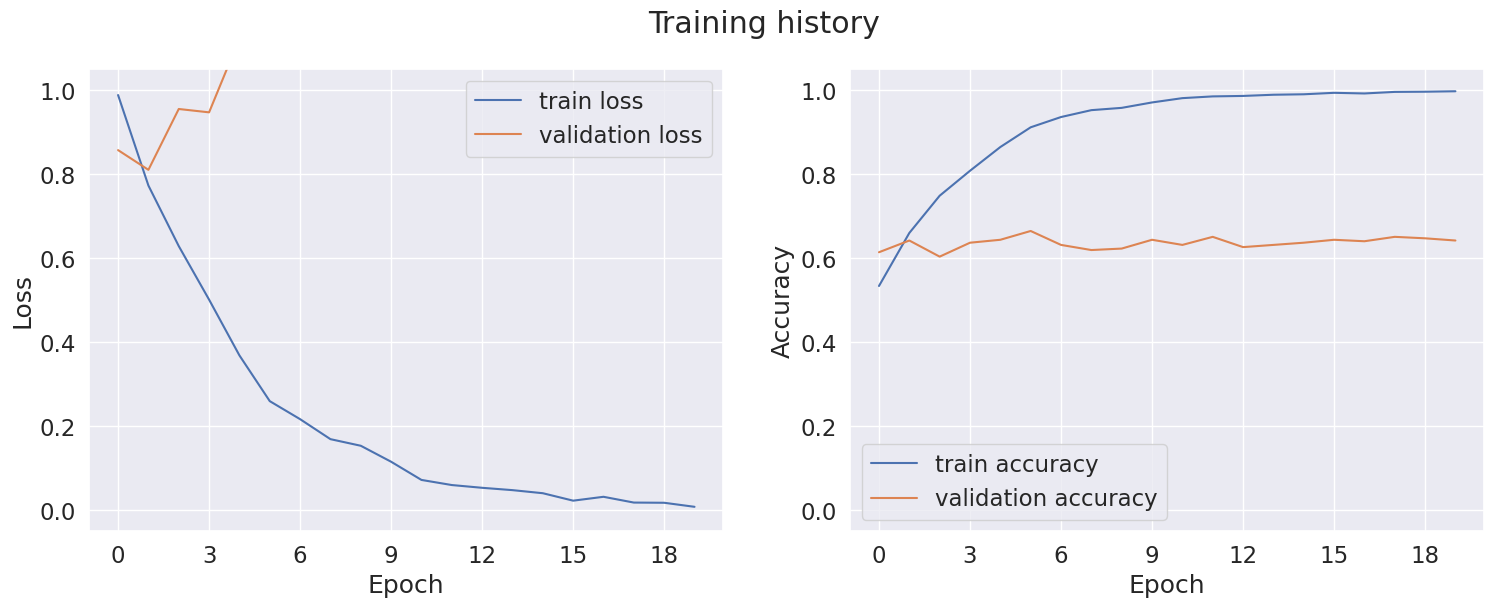

In [73]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [74]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 4,579 examples with batch size 16...

Tokenizing 4,579 samples...
  Tokenized 0 samples.
  Tokenized 500 samples.
  Tokenized 1,000 samples.
  Tokenized 1,500 samples.
  Tokenized 2,000 samples.
  Tokenized 2,500 samples.
  Tokenized 3,000 samples.
  Tokenized 3,500 samples.
  Tokenized 4,000 samples.
  Tokenized 4,500 samples.
DONE.
     4,579 samples

     4,579 samples after sorting

Creating batches of size 16...

  DONE - Selected 287 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 287 test batches...
  Batch      30  of      287.    Elapsed: 0:00:01.  Remaining: 0:00:11
  Batch      60  of      287.    Elapsed: 0:00:03.  Remaining: 0:00:10
  Batch      90  of      287.    Elapsed: 0:00:04.  Remaining: 0:00:08
  Batch     120  of      287.    Elapsed: 0:00:05.  Remaining: 0:00:07
  Batch     150  of      287.    Elapsed: 0:00:06.  Remaining: 0:00:06
  Batch     180  of      287.    Elapsed: 0:00:08.  Remaining: 0:00:05

In [75]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       1.00      1.00      1.00      1431
     neutral       1.00      1.00      1.00      1183
    negative       1.00      1.00      1.00      1965

    accuracy                           1.00      4579
   macro avg       1.00      1.00      1.00      4579
weighted avg       1.00      1.00      1.00      4579



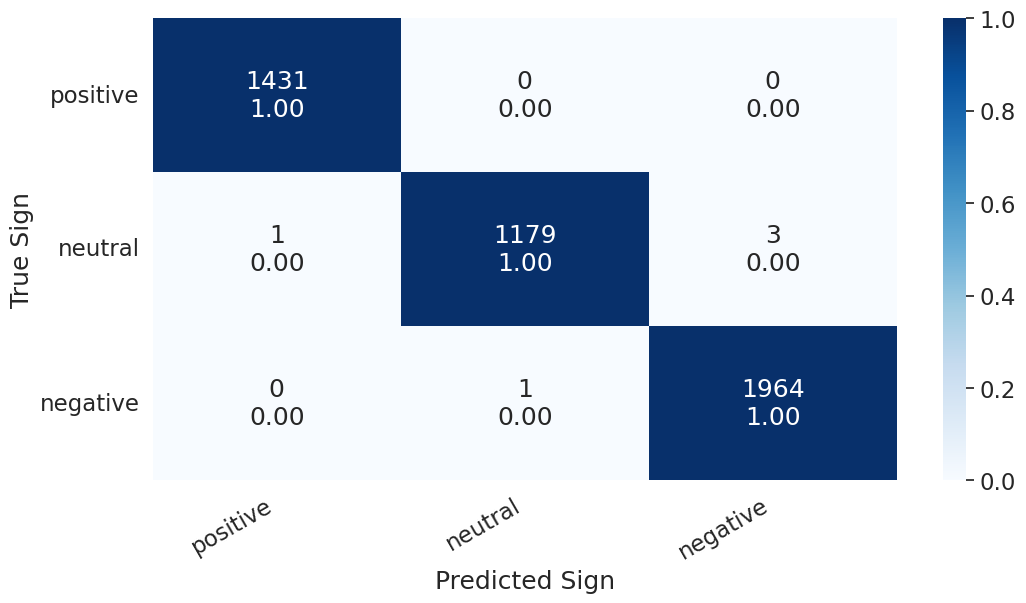

In [76]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [77]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 573 examples with batch size 16...

Tokenizing 573 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       573 samples

       573 samples after sorting

Creating batches of size 16...

  DONE - Selected 36 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 36 test batches...
  Batch       4  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      28  of   

In [78]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.60      0.59      0.60       183
     neutral       0.61      0.64      0.63       165
    negative       0.70      0.68      0.69       225

    accuracy                           0.64       573
   macro avg       0.64      0.64      0.64       573
weighted avg       0.64      0.64      0.64       573



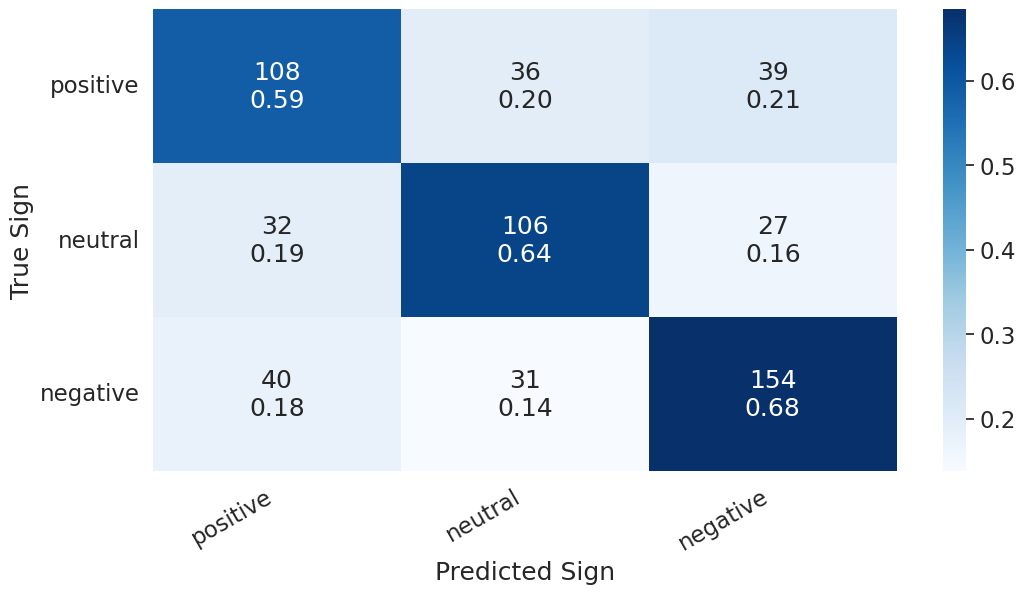

In [79]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [80]:
test_df

,PID,text,labels
3887,3888,জয় বাংলা স্লোগান যারা দেয় সব গুলায় চোর বাটপার,negative
4463,4464,পদ্মা সেতুর নির্মাণ প্রকল্পের মতই আপনাদের তথ্য...,positive
4353,4354,সত্যি বলতে শেখ হাসিনা না হলে এই পদ্মা সেতু হত ...,positive
1973,1974,রাস্তা এবং তার চারপাশ সুন্দর করার দায়িত্ব সরকা...,positive
2603,2604,কত টাকা শেখ পরিবারের পকেটে ঢুকেছে তার হিসাব জা...,neutral
...,...,...,...
2715,2716,জাতির আব্বা বলেছিল না? চাটার দল সব খায়। উনার ...,negative
3858,3859,ডঃ মুহাম্মদ ইউনুস স্যার খেলা দেখতে ভালোই লাগছে...,positive
3874,3875,সব কিছুর লাভ দেখলে হয় না। কিছু আছে প্রয়জন-যেমন...,positive
2473,2474,এই।।সমষত।।উন্নয়ন। কথা।।শুনলে <>চোখে।। পানি।।এস...,neutral


## Loading `test_sentences`

In [81]:
test_sentences = test_df['text'].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [82]:
test_ids

array([3887, 4463, 4353, 1973, 2603, 1235, 4842, 4957, 5216, 4006,  290,
        734, 2535,  465, 4169,  800, 4792, 2571, 4269, 4905, 1564, 3857,
        642, 1870, 3405, 5002, 2646, 4438, 2644,  724,  296, 3870, 4573,
       4385, 1049, 2218, 4702, 4357, 3919,  443, 2654, 2053, 5174, 3323,
       1501, 2764,  879,  491, 3647, 1599, 1087, 3366, 4260, 4918, 3754,
       5582, 2439, 1158, 5595,  381, 4630,  653, 3612, 2259, 4554,  245,
        438, 4480,  351, 1741, 2306,  677, 1467, 5391, 1057, 1788,  157,
       3606, 2653, 2602, 4907, 1988,  319, 4564, 3909, 4652, 4386, 3459,
       4853,  751, 4802, 2702, 5086, 4030, 5361, 4370, 4856, 4419,  497,
       1886, 1425, 2549,  259, 1737, 2436,  748, 1543, 4661, 1322, 1620,
        401,  373, 4145, 2409, 5619,   90, 1215, 3690, 2252,  681, 1033,
        142, 2910, 2899,  177, 3841, 1022, 5129, 1782, 3409, 3109, 3393,
       2876, 3435,  132, 5339, 2313, 3129, 4960, 3226, 4603,   15, 1328,
       4818,  429, 3878, 1321, 1244, 4707, 5350, 43

In [83]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 572 examples with batch size 16...

Tokenizing 572 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       572 samples

       572 samples after sorting

Creating batches of size 16...

  DONE - Selected 36 batches.

Padding out sequences within each batch...
  DONE.


In [84]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 36 test batches...
  Batch       4  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      28  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      32  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [85]:
test_sentences

array(['জয় বাংলা স্লোগান যারা দেয় সব গুলায় চোর বাটপার',
       'পদ্মা সেতুর নির্মাণ প্রকল্পের মতই আপনাদের তথ্যচিত্রও অনেক দারুণ হোয়েছে। 💖',
       'সত্যি বলতে শেখ হাসিনা না হলে এই পদ্মা সেতু হত না,এতো বড় রিক্স নিয়ে,এতো বড় প্রজেক্ট,এতো টাকা খরচ করে বলতে হবে হাসিনার সাহস আছে ধন্যবাদ মাননীয় প্রধানমন্ত্রী',
       'রাস্তা এবং তার চারপাশ সুন্দর করার দায়িত্ব সরকারের,আর এর সোন্দয ধরে রাখার দায়িত্ব সাধারণ জনগনের,',
       'কত টাকা শেখ পরিবারের পকেটে ঢুকেছে তার হিসাব জাতির সামনে তুলে ধরার জন্য অনুরোধ করা হচ্ছে',
       'শুধু উদ্বোধন করতে ৮৯ কোটি টাকা লাগে আল্লাহ আমরা কোন দেশে জন্মগ্রহণ করলাম',
       'গতি লিমিট করতে হবে,,, আর অটো সিসি কেমেরা বসাতে হবে,,,, জেই গতি দেওয়া থাকবে তার চেয়ে বেশী গতিতে গাড়ি চালালেই অটো মালমা হয়ে জাবে,,, কঠিন আইন জারি করতে হবে',
       'এটা মনে হয় ড.ইউনুসের কাজ।সে হয়তো কোন কালো যাদু করেছে।',
       'এখন থেকে ট্রাক চলাচল নিষিদ্ধ করা হোক',
       'সিঙ্গাপুর না, আমেরিকা হবে!কি খাবি আগে সেটা ভাব, সিঙ্গাপুর পরে বানাস < ="://../?=9&;=158">2:38</> ।',
       'আলহামদুলিল্লাহ আ

In [86]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 572 examples with batch size 16...

Tokenizing 572 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       572 samples

       572 samples after sorting

Creating batches of size 16...

  DONE - Selected 36 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 36 test batches...
  Batch       4  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch       8  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch      12  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      16  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      28  of   

In [87]:
y_pred

array([1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 2, 0, 0,
       0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0,
       2, 1, 2, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0, 1, 2, 2,
       2, 0, 2, 2, 0, 2, 0, 0, 2, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2,
       0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 0, 2,
       2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 0, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 0, 1, 1, 1, 1, 2,
       2, 0, 1, 0, 2, 0, 0, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 1,
       2, 0, 0, 1, 2, 0, 1, 1, 2, 0, 1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0,
       2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0, 0, 0, 2, 2,
       2, 2, 1, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 2, 2, 0, 0, 1, 2, 2, 2, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2,
       1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 1,

## Evaluating accuracy over test set

In [88]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 36 test batches...
  Batch       4  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch       8  of       36.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch      12  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      16  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      28  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      32  of       36.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [89]:
print(y_preds)

[1 0 0 1 1 1 2 0 1 1 1 0 1 2 1 1 2 2 0 2 0 0 0 2 0 0 2 2 0 0 2 0 2 2 2 2 2
 0 2 2 0 0 2 0 2 1 2 0 1 2 0 1 2 1 2 2 1 2 1 0 1 0 0 1 2 2 2 0 2 2 0 2 0 0
 2 1 2 0 0 2 0 2 2 1 2 2 2 2 2 2 2 1 1 2 2 0 0 0 2 2 1 0 2 2 2 0 2 0 2 2 0
 1 2 1 1 1 2 2 1 2 1 1 1 1 1 1 0 0 2 2 0 2 2 2 0 2 2 2 2 1 2 1 0 1 0 1 2 2
 2 2 2 0 0 2 2 0 0 2 1 1 1 2 1 2 2 0 0 0 2 1 0 1 1 1 1 2 2 0 1 0 2 0 0 0 1
 1 2 2 1 2 2 2 2 0 2 1 2 1 2 0 0 1 2 0 1 1 2 0 1 2 0 0 0 2 2 2 0 2 0 0 2 0
 2 2 2 2 1 2 2 2 0 1 2 2 2 2 1 0 0 0 2 2 2 2 1 2 2 2 0 1 0 0 2 0 0 0 2 0 1
 0 0 0 0 1 0 1 1 1 2 2 0 0 1 2 2 2 1 2 0 1 0 1 2 2 2 2 1 2 2 1 0 0 1 1 1 0
 2 0 1 0 1 2 1 2 2 0 2 2 1 0 0 0 1 2 0 2 2 1 2 2 2 0 2 2 0 0 2 1 0 0 1 2 0
 1 0 2 2 0 2 2 1 0 1 1 0 2 0 0 2 0 1 0 2 1 2 1 0 1 1 2 0 0 0 1 2 2 0 1 0 1
 2 1 0 1 0 2 1 1 2 1 2 1 2 2 2 1 2 1 2 1 1 2 2 2 2 2 2 0 2 1 0 2 2 0 2 0 2
 0 2 0 0 0 0 0 0 2 0 2 1 2 0 0 2 1 0 1 2 2 1 1 0 0 1 1 0 0 0 2 0 2 1 2 1 2
 2 1 0 1 0 0 0 0 2 2 1 1 1 1 1 1 0 0 1 2 1 0 2 1 0 0 2 2 2 2 1 2 0 0 0 0 0
 1 1 1 0 2 1 2 1 1 2 2 0 

In [90]:
print(y_ids)

[5049 3632  952   17 3405 5174 1988 4734 4059  765 5709 3732 4741  121
 1212 4702 2091 4419 5101 1860 1383  354 4689 5083 4842 2473 1831 1025
 3586  286 4353 4554 4512 2053 2337 4590 5608 2650 2168 5619  279 4390
 4017 3109 4584 2749 2484 5176 1769 3187 4006 1057 4487 4121  486 2277
 3094 3661 3878 3886 2646 3590 3875 2486 4240 2402 3366 5129 2173  408
  856 2154 1255 5630 5062  798   61 1253 5598 4775 4357 2702 4538 2699
 5568 2985 4270  479 1144 1973 5582  751 3690 3435 4060 2671 3195 5322
 4480   90  410 3125 1183 4328 1509 1934  624  877  381 4149 3837  677
 5633 1121  272 1741 5086 1879 2758 1630 4095 5185 2259 5042 5386 3593
 3210  240 4065  109 5510 5369 3919  879 2910 3130 5410  829 1109 2644
 4564 2534  393  149 1543 2252  106 2018 1268 5003 3164   63 4939 4463
 3074 4783 3622 5298 1235 3647  447 5391  964 2142 3565 5592 3666 3783
 1344 3090 5216 1788 1782 5435 4063 5072 2598 1448 2700 3887 4385  491
 1737 5081 5229 1223 3012 3071 1046 2195 5301  292 4145 3621  251 2951
 1425 

In [91]:
le.inverse_transform(y_preds)

array(['neutral', 'negative', 'negative', 'neutral', 'neutral', 'neutral',
       'positive', 'negative', 'neutral', 'neutral', 'neutral',
       'negative', 'neutral', 'positive', 'neutral', 'neutral',
       'positive', 'positive', 'negative', 'positive', 'negative',
       'negative', 'negative', 'positive', 'negative', 'negative',
       'positive', 'positive', 'negative', 'negative', 'positive',
       'negative', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'negative', 'positive', 'negative', 'positive', 'neutral',
       'positive', 'negative', 'neutral', 'positive', 'negative',
       'neutral', 'positive', 'neutral', 'positive', 'positive',
       'neutral', 'positive', 'neutral', 'negative', 'neutral',
       'negative', 'negative', 'neutral', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'positive', 'negative', 'negative', 'positive', 'neutral',
  

<Axes: xlabel='count'>

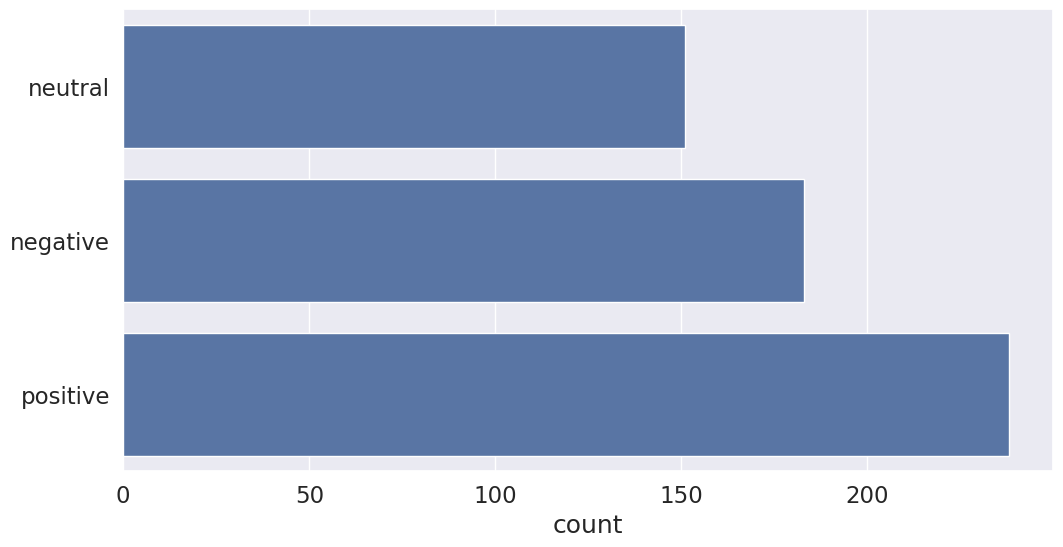

In [92]:
sns.countplot(y =le.inverse_transform(y_preds))

In [93]:
len(y_ids)

572

In [94]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['neutral', 'negative', 'negative', 'neutral', 'neutral', 'neutral',
       'positive', 'negative', 'neutral', 'neutral', 'neutral',
       'negative', 'neutral', 'positive', 'neutral', 'neutral',
       'positive', 'positive', 'negative', 'positive', 'negative',
       'negative', 'negative', 'positive', 'negative', 'negative',
       'positive', 'positive', 'negative', 'negative', 'positive',
       'negative', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'negative', 'positive', 'negative', 'positive', 'neutral',
       'positive', 'negative', 'neutral', 'positive', 'negative',
       'neutral', 'positive', 'neutral', 'positive', 'positive',
       'neutral', 'positive', 'neutral', 'negative', 'neutral',
       'negative', 'negative', 'neutral', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'positive', 'negative', 'negative', 'positive', 'neutral',
  

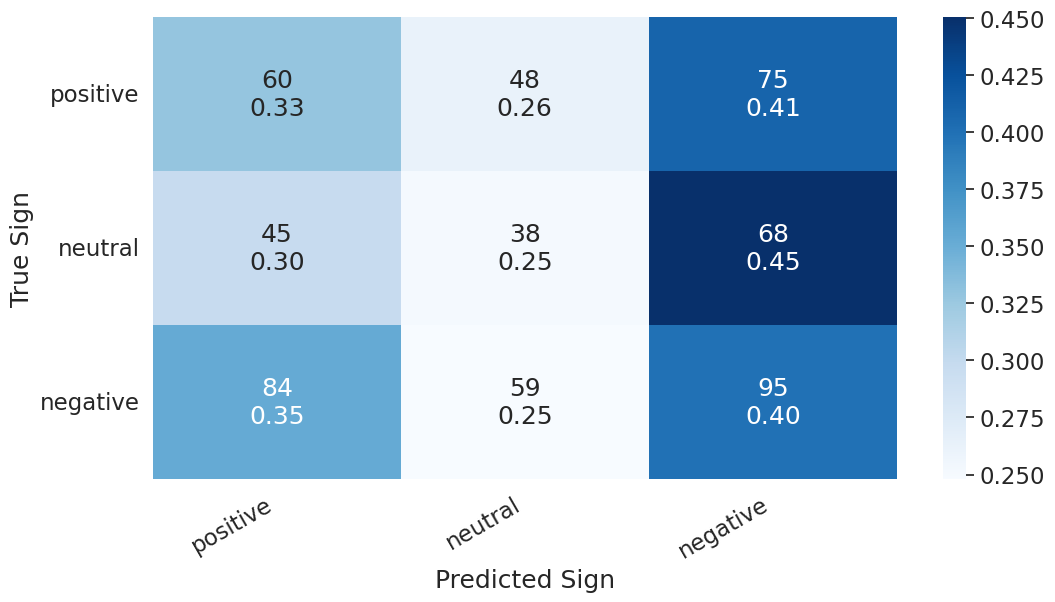

In [95]:
cm = confusion_matrix(y_pred, test_labels)
show_confusion_matrix(cm, class_names)

Classification Report:
              precision    recall  f1-score   support

    positive     0.3279    0.3175    0.3226       189
     neutral     0.2517    0.2621    0.2568       145
    negative     0.3992    0.3992    0.3992       238

    accuracy                         0.3374       572
   macro avg     0.3262    0.3262    0.3262       572
weighted avg     0.3382    0.3374    0.3378       572



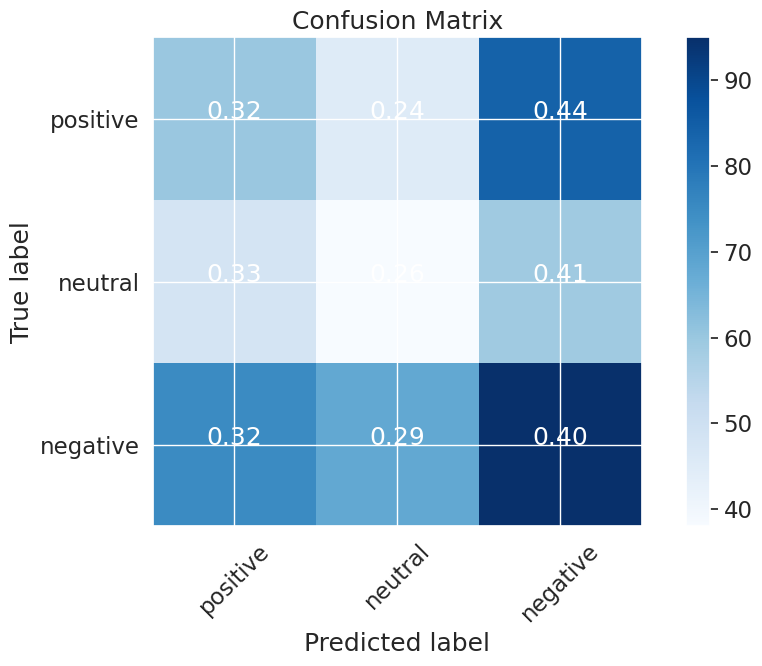

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_pred and test_labels are defined
# Convert predictions to class labels if they are probabilities (if needed)
# y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=class_names, zero_division=0, digits=4))

# Create the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Function to display the confusion matrix
def show_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Display the confusion matrix
show_confusion_matrix(cm, class_names)
